In [1]:
import random

from DrawSolution import draw_all_pallets
from UnderstandPallets import understand_pallets
from PackingQuality import packing_quality
from class_item import Item
from class_permutation import Permutation
import copy
import time
import random


import generate
import pallet


eps = 1

poligon1 = [[0,1,0], [1,1,1], [0,1,0]]
poligon2 = [[1,1], [1,0]]
poligon3 = [[1,1,1], [0,1,0]]

points_1 = [[0,3], [2,0], [3,1], [2,1], [1, 4]]
points_2 = [[0,0], [1,0], [1,8], [0,8]]
points_3 = [[0,3], [2,0], [2,1], [3,2], [1, 4]]

sq_points = [[0,0], [0,2], [2,2], [2,0]]
sq_matrix = [[1,1], [1,1]]
# point_23 = [[0,0], [3,0], [3,2], [0,2]]
point_23 = [[0,0], [0,3], [2,3], [2,0]]
matrix_23 = [[1,1,1], [1,1,1]]
# point_big =[[0,0], [3,0],[3,3],[6,3], [6,9], [0,9]]
point_big =[[0,0], [0,3],[3,3],[3,6], [9,6], [9,0]]
# matrix_big = [[1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,0,0,0]]
matrix_big = [[1,1,1,0,0,0], [1,1,1,0,0,0], [1,1,1,0,0,0], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1]]
# point_ugol = [[0,4], [4,4], [4,0], [5,0], [5,5], [0,5]]
point_ugol = [[4,0], [4,4], [0,4], [0,5], [5,5], [5,0]]
# matrix_ugol = [[1,1,1,1,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1]]
matrix_ugol = [ [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1],[1,1,1,1,1]]
# point_ugol_niz = [[0,3], [4,3], [4,0], [5,0], [5,4], [0,4]]
point_ugol_niz = [[3,0], [3,4], [0,4], [0,5], [4,5], [4,0]]
# matrix_ugol_niz = [[1,1,1,1,1], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1]]
matrix_ugol_niz = [[0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,1], [1,1,1,1,1]]
# point_gor = [[0,0], [7,0], [7,1], [3,1], [3,3], [0,3]]
point_gor = [[0,0], [0,7], [1,7], [1,3], [3,3], [3,0]]
# matrix_gor = [[1,1,1,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,1,1,1]]
matrix_gor = [[1,1,1,1,1,1,1], [1,1,1,0,0,0,0], [1,1,1,0,0,0,0]]


poligons = [copy.deepcopy(sq_points), copy.deepcopy(sq_points), copy.deepcopy(sq_points), copy.deepcopy(sq_points), copy.deepcopy(sq_points), copy.deepcopy(sq_points), copy.deepcopy(sq_points),
            copy.deepcopy(point_23),copy.deepcopy(point_23), copy.deepcopy(point_23),
            copy.deepcopy(point_big),
            copy.deepcopy(point_ugol),
            copy.deepcopy(point_ugol_niz),
            copy.deepcopy(point_gor)]

# poligons = [copy.deepcopy(points_2),copy.deepcopy(points_2)]
items = [Item(i, poligons[i]) for i in range(len(poligons))]



for i in range(7):
    items[i].matrix = copy.deepcopy(sq_matrix)

items[7].matrix = copy.deepcopy(matrix_23)
items[8].matrix = copy.deepcopy(matrix_23)
items[9].matrix = copy.deepcopy(matrix_23)
items[10].matrix = copy.deepcopy(matrix_big)
items[11].matrix = copy.deepcopy(matrix_ugol)
items[12].matrix = copy.deepcopy(matrix_ugol_niz)
items[13].matrix = copy.deepcopy(matrix_gor)





matrix = [[0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,0,0,0,0]]

eps = 1
pallet_width = 11
pallet_leight = 11
# numPoligons = 5

# g= generate.Generator(pallet_width, pallet_leight, numPoligons)
# g.start(eps)
# items = g.data

pal = pallet.Pallet(0, pallet_width, pallet_leight, eps)


In [2]:


def find_lb_coordinates(items, eps):
    for item in items:
        item.lb_x = item.lb_x * eps
        item.lb_y = item.lb_y * eps
    return items

def fit_item(pallet, item):
    for i in range(len(pallet[0])):
        for j in range(len(pallet)):
            exit = False
            # условия, что объект влезает
            if len(item.matrix) + i <= len(pallet) and len(item.matrix[0]) + j <= len(pallet[0]):
                # располагаем объект
                for p in range(len(item.matrix)):
                    for k in range(len(item.matrix[0])):
                        # решаем есть ли пересечение
                        if pallet[i+p][j+k] + item.matrix[p][k] == 2:
                            exit = True
                            break
                    if exit:
                        break
            else:
                exit = True
            # если пересечений нет и элемент влезает, то добавляем его
            if not exit:
                item.lb_x = i
                item.lb_y = j
                for p in range(len(item.matrix)):
                    for k in range(len(item.matrix[0])):
                        pallet[i+p][j+k] += item.matrix[p][k]
                break
        if not exit:
            break

    return pallet, exit

def fit_pallets(matrix, items, eps):
    pallets = []
    pallets.append(copy.deepcopy(matrix))
    for item in items:
        i=0
        exit = True
        while exit and i<len(pallets):
            pallets[i], exit = fit_item(pallets[i], item)
            if exit and i==(len(pallets)-1):
                pallets.append(copy.deepcopy(matrix))
            if not exit:
                item.pallet_number = i
                # print(i)
            i+=1
    find_lb_coordinates(items, eps)

    return pallets, items

In [3]:
def swap(list, pos1, pos2):

    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list

def locSearch(matrix, poligons, eps):

    n = len( poligons)
    pal, new_polygons = fit_pallets(matrix,  poligons, eps)

    objVal = [len(pal), packing_quality(new_polygons, eps)]

    poligonsBest = copy.deepcopy(poligons)

    betterNeighboor = (0,0)
    stop = False
    while not stop:
        stop = True
        for i in range(n):
            for j in range(i + 1, n):
                pal, new_polygons = fit_pallets(matrix, swap(copy.deepcopy(poligonsBest), i, j), eps)
                val = [len(pal), packing_quality(new_polygons, eps)]
                if val[0] < objVal[0]:
                    stop = False
                    objVal = val
                    betterNeighboor = (i,j)
                    poligons = new_polygons
                elif val[0] == objVal[0] and val[1] < objVal[1]:
                    stop = False
                    objVal = val
                    betterNeighboor = (i,j)
                    poligons = new_polygons
                if betterNeighboor[1] != 0:
                    swap( poligonsBest, betterNeighboor[0], betterNeighboor[1])
    # print('выход')
    return poligons

In [4]:
def crossover_type1(parent1, parent2):
    child = parent1[:int(len(parent1)/2)]
    for i in range(len(parent1)):
        if parent2[i] not in child:
            child.append(parent2[i])
    return child

def crossover_type2(parent1, parent2):
    child = parent2[:int(len(parent2)/2)]
    for i in range(len(parent1)):
        if parent1[i] not in child:
            child.append(parent1[i])
    return child

In [5]:
def genetic_local_search(items, matrix, eps, pallet_width, pallet_leight):
    record = [len(items), 100000000] # ограничение сверху, !надо придумать, как ограничить высоту упаковки
    record_permutation = 0

    population = []

    k = 9 # размер изначальной популяции

    # создаём начальную случайную популяцию и находим её рекорд
    i=0
    while len(population)<k:
        child = sorted(items, key=lambda A: random.random())
        child = locSearch(matrix, copy.deepcopy(child), eps)
        if child not in population:
            result, new_polygons = fit_pallets(matrix, copy.deepcopy(child), eps)
            population.append(Permutation(child, value= [len(result), packing_quality(new_polygons, eps)]))
            if record[0] > population[i].value[0]:
                print('меньше палет')
                record = population[i].value
                record_permutation = population[i]
            elif record[0] == population[i].value[0] and record[1] > population[i].value[1]:
                print('компактнее')
                record = population[i].value
                record_permutation = population[i]
            i+=1
    print('заполнили начальную популяцию')
    # удаляем из списка рекорд
    population.remove(record_permutation)
    champions = population
    sorted(champions, key=lambda champion: champion.value) # есть вероятность, что сортирует не правильно
    start_time = time.time()
    work_time = 0
    find_best = True
    while work_time < 10: # ограничение по времени работы в секундах
        # создаём новую популяцию, если чемпион новый
        if find_best:
            print('новый чемпион')
            population = []
            for parent in champions:
                child_1 = crossover_type1(record_permutation.items, parent.items)
                child_2 = crossover_type2(record_permutation.items, parent.items)
                child_1 = locSearch(copy.deepcopy(matrix), copy.deepcopy(child_1), eps)
                child_2 = locSearch(copy.deepcopy(matrix), copy.deepcopy(child_2), eps)
                result, new_polygons = fit_pallets(copy.deepcopy(matrix), copy.deepcopy(child_1), eps)
                population.append(Permutation(child_1, value= [len(result), copy.deepcopy(packing_quality(new_polygons, eps))]))
                result, new_polygons = fit_pallets(copy.deepcopy(matrix), copy.deepcopy(child_2), eps)
                population.append(Permutation(child_2, value=[len(result), copy.deepcopy(packing_quality(new_polygons, eps))]))
        # создаём новую популяцию, если чемпион старый
        else:
            print('старый чемпион')
            old_population = copy.deepcopy(population)
            population = []
            for parent in old_population:
                child_1 = crossover_type1(record_permutation.items, parent.items)
                child_2 = crossover_type2(record_permutation.items, parent.items)
                child_1 = locSearch(copy.deepcopy(matrix), copy.deepcopy(child_1), eps)
                child_2 = locSearch(copy.deepcopy(matrix), copy.deepcopy(child_2), eps)
                result, new_polygons1 = fit_pallets(copy.deepcopy(matrix), copy.deepcopy(child_1), eps)
                population.append(Permutation(child_1, value= [len(result), copy.deepcopy(packing_quality(new_polygons1, eps))]))
                result, new_polygons2 = fit_pallets(copy.deepcopy(matrix), copy.deepcopy(child_2), eps)
                population.append(Permutation(child_2, value=[len(result), copy.deepcopy(packing_quality(new_polygons2, eps))]))
        find_best = False
        # чистим и сортируем всех новых особей
        for permutation in population:
            # print('рекорд', record_permutation.value)
            # удаляем повторы
            if permutation == record_permutation or permutation in champions or population.count(permutation)>1:
                population.remove(permutation)
            # если мы получили лучшую
            elif permutation.value[0] < record_permutation.value[0] or (permutation.value[0] == record_permutation.value[0] and permutation.value[1] < record_permutation.value[1]):
                population.append(copy.deepcopy(record_permutation))
                record_permutation = permutation
                population.remove(record_permutation)
                find_best = True
        # пересматриваем чемпионов
            if permutation.value[0] < champions[0].value[0] or (permutation.value[0] == champions[0].value[0] and permutation.value[1] < champions[0].value[1]):
                champions.remove(champions[0])
                champions.append(copy.deepcopy(permutation))
                population.remove(permutation)
                sorted(champions, key=lambda champion: champion.value) # есть вероятность, что сортирует не правильно
        work_time = time.time() - start_time
        print(work_time)

    rec, rec_items = fit_pallets(matrix, copy.deepcopy(record_permutation.items), eps)
    draw_all_pallets(understand_pallets(rec_items), pallet_width, pallet_leight)
    return rec

меньше палет
компактнее
меньше палет
заполнили начальную популяцию
новый чемпион
31.61776304244995


[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]

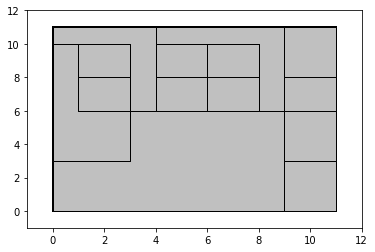

In [6]:
genetic_local_search(items, pal.matrix, eps, pallet_width, pallet_leight)
# pallets, items = fit_pallets(matrix, locSearch(matrix, items, eps), eps)
# draw_all_pallets(understand_pallets(items), pallet_width, pallet_leight)
